In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
from scipy import stats
from scipy.special import inv_boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

In [13]:
file = 'data/salesdaily.csv'
df = pd.read_csv(file)

In [14]:
df.shape

(2106, 13)

The dataset includes 2106 observations and 13 columns. <br>
Out of which 5 are time marks and rest 6 are variables those represents amount of sales in units for several Anatomical Therapeutic Chemical Classification (ATC)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 13 columns):
datum           2106 non-null object
M01AB           2106 non-null float64
M01AE           2106 non-null float64
N02BA           2106 non-null float64
N02BE           2106 non-null float64
N05B            2106 non-null float64
N05C            2106 non-null float64
R03             2106 non-null float64
R06             2106 non-null float64
Year            2106 non-null int64
Month           2106 non-null int64
Hour            2106 non-null int64
Weekday Name    2106 non-null object
dtypes: float64(8), int64(3), object(2)
memory usage: 214.0+ KB


So, there is perfectly rafinated data from Kaggle comprises two type of variables: float64, int64 and no one NaN/missing value. <br>
There is strong likelihood that you never meet so clear data from the real world.

In [16]:
df.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday
3,1/5/2014,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday
4,1/6/2014,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday


- M01AB - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances
- M01AE - Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives
- N02BA - Other analgesics and antipyretics, Salicylic acid and derivatives
- N02BE - Other analgesics and antipyretics, Pyrazolones and Anilides
- N05B - Psycholeptics drugs, Anxiolytic drugs
- N05C - Psycholeptics drugs, Hypnotics and sedatives drugs
- R03 - Drugs for obstructive airway diseases
- R06 - Antihistamines for systemic use

In [17]:
#Select the Analgesics market for next steps
data = df[['N02BE','N02BA']].copy()
df.datum = pd.to_datetime(df.datum)
data = data.set_index(df.datum)

In [20]:
#Combine ATC codes related to the same market in one
data['volume_sales'] = data['N02BA'] + data['N02BE']
data = data.drop(columns=['N02BA', 'N02BE'])

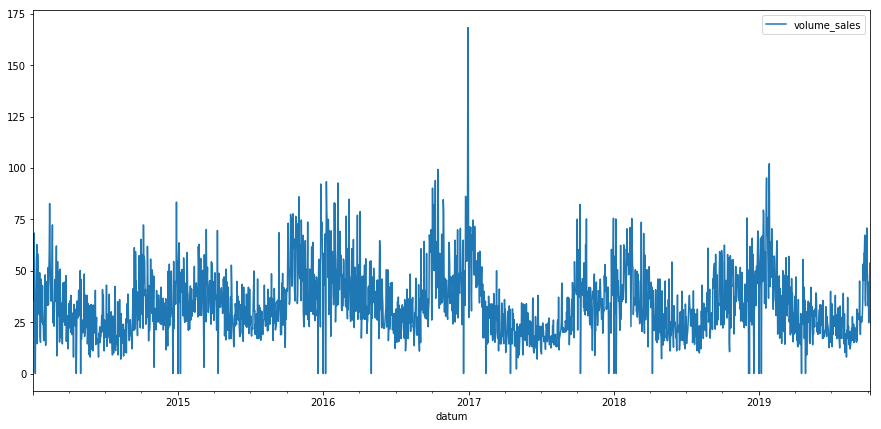

In [21]:
data.plot(figsize=(15,7))

In [22]:
#Split data for 2 independent groups. The first one we will use to models training and second one as test
df_train = data['01/01/2017':'12/31/2018'].copy()
df_test = data['1/1/2019':].copy()

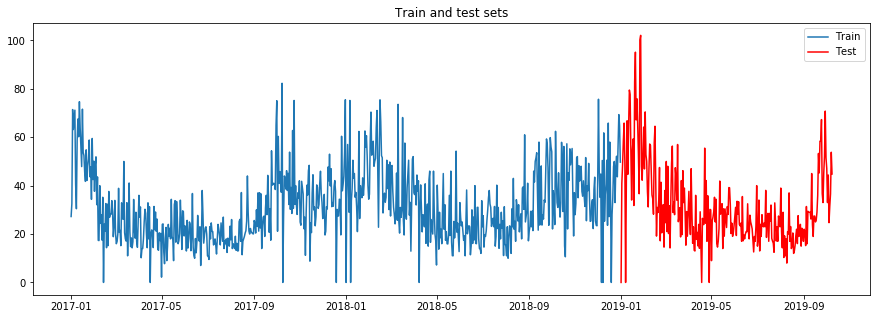

In [23]:
#Let's looks on those
plt.figure(figsize=(15,5))
plt.plot(df_train.index, df_train['volume_sales'], label='Train')
plt.plot(df_test.index, df_test['volume_sales'], color='r', label='Test')
plt.legend()
plt.title('Train and test sets')
register_matplotlib_converters()
plt.show()

We have to create some functions to generate features those we will us as predictors inside our's models. <br>
Pay your attention there are functions creates dummi features for a day time marks and one to scaled predictors

### Strategy 1 - "Create new features base on previously predicted values"

In this case we will use some historical observations to make first predictions and then we will creating features using only already predicted values. That way gives us leverage to make a forecast on unlimited time steps ahead. However, an accuracy of our forecasting will decrease each new prediction.

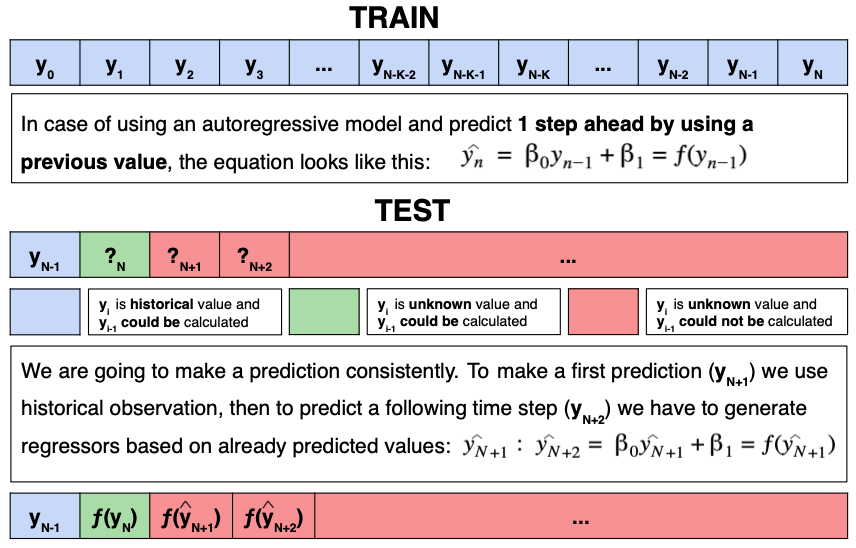

In [18]:
def linreg(X):
    
    n = X.shape[0]
    x = np.concatenate((np.ones(n),
                        np.arange(n)),
                      ).reshape(2, n).T
    
    y = X.reshape(-1,1)
    theta = np.linalg.pinv(x.dot(x.T)).dot(x).T.dot(y)

    return np.array([[1, n]]).dot(theta)

In [19]:
def create_features(data, lags_list):
    
    X = pd.DataFrame(data.values.ravel(), index=data.index, columns=['y'])
    
    for window in lags_list:
        X['lin_reg_{}'.format(window)] = X['y'].shift(1).rolling(window=window).apply(linreg, raw=True)
        X['shift_{}'.format(window)] = X['y'].shift(window)
        X['diff_{}'.format(window)] = X['y'].shift(1).diff(window)
        X['rolling_mean_{}'.format(window)] = X['y'].shift(1).rolling(window=window).mean()
        X['rolling_max_{}'.format(window)] = X['y'].shift(1).rolling(window=window).max()
        X['rolling_std_{}'.format(window)] = X['y'].shift(1).rolling(window=window).std()
        X['rolling_min_{}'.format(window)] = X['y'].shift(1).rolling(window=window).min()
        
    X = X.fillna(np.nanmedian(X))
    
    return X.drop('y', axis=1)

In [20]:
def create_dummies(data):
    
    X = pd.DataFrame({'day_of_week' : data.index.weekday_name}, data.index)
    days = pd.get_dummies(X['day_of_week'])
    result = pd.concat([data, days], axis=1, sort=False)
    
    return result

In [21]:
def scaler(data):
    
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    result = pd.DataFrame(scaled, columns=[data.columns], index=data.index)
    
    return result

In [22]:
lags = [2,7,14]
X_train = scaler(create_dummies(create_features(df_train, lags)))

In [23]:
model_ridge = Ridge()
model_lasso = Lasso()
model_tree = DecisionTreeRegressor()
model_forest = RandomForestRegressor()
models = {'forest': model_forest,
          'lasso': model_lasso,
          'ridge': model_ridge,
          'tree': model_tree}

In [65]:
def train(X, actual, model, n_splits=10):
    
    cv = TimeSeriesSplit(n_splits=n_splits)
    y = []
    i = 0 

    for train, test in cv.split(X):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = actual[train], actual[test]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        if i == 0:
            y.extend(model.predict(X_train))
        i+=1
        y.extend(y_pred)
        
    return y

In [66]:
df = pd.DataFrame()
for model in models.items():
    df[model[0]] = train(X_train, df_train.values.ravel(), model[1])

In [26]:
def model_to_chart(y, y_pred, model_name, index):
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(15,5))
    ax.set_title('Model:{}, MAE = {:.3f}'.format(model_name, mean_absolute_error(y, y_pred)))
    plt.plot(index, y, label='True')
    plt.plot(index, y_pred, label='Predicted')
    plt.plot(index, y - y_pred, label='error', alpha=.3)
    plt.legend()
    register_matplotlib_converters();

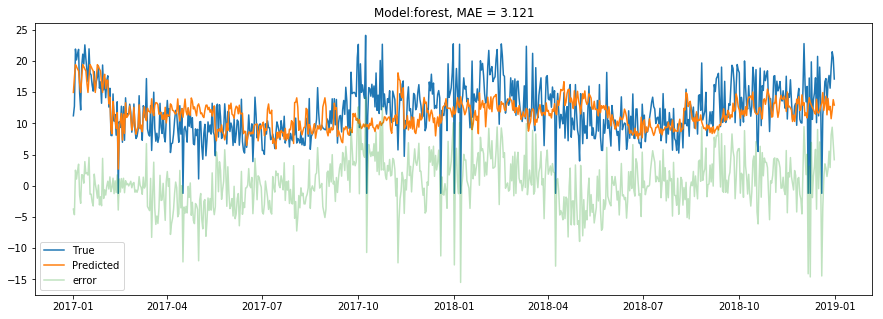

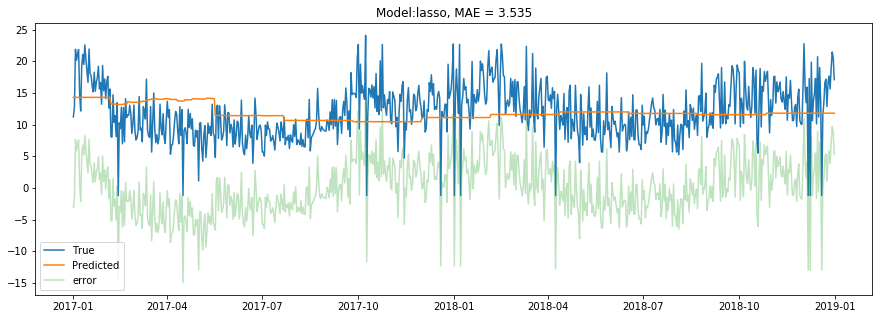

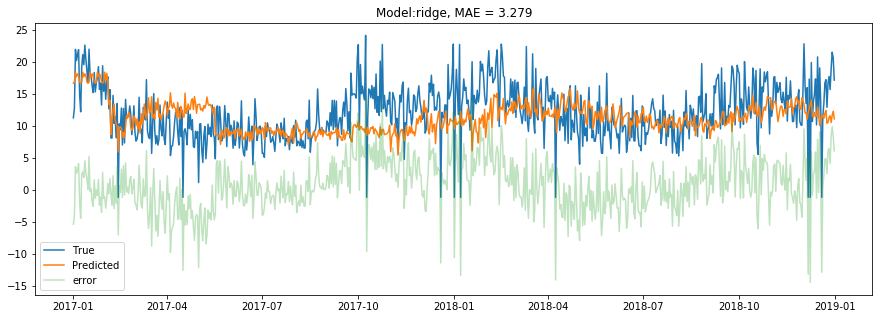

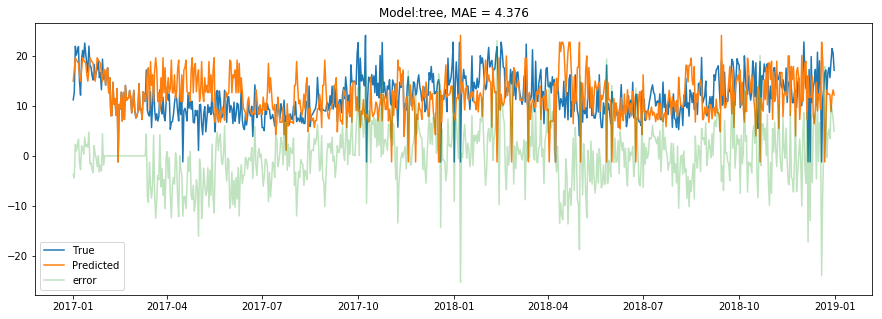

In [68]:
for model in models.items():
    model_to_chart(y=df_train[:3000].values.ravel(), 
                y_pred= df[:3000][model[0]].values, 
                index = df_train[:3000].index, 
                model_name=model[0])

In [28]:
def create_dates(data, n_steps_prediction):
    
    'adds new dates to the given dataset'
    
    start_date = data.index[-1] + pd.DateOffset(1) #define a latest date in the given dataset
    new_date = pd.date_range(start_date, periods=n_steps_prediction) #create dataset with dates
    
    return data.append(pd.DataFrame(index=new_date), sort=True) #add new dates to the main df

In [32]:
def forecast_maker(models, data, n_steps, lags_list):
    
    'makes a n_steps time steps ahead forecast'
    
    df = create_dates(data, n_steps) #create new dates
    
    for model in models.items(): #run over the models
        
        df[model[0]] = df.values[:,0] #pass historical observation to make first predictions 

        for i in range(0, n_steps-1):
            x_features = scaler(create_dummies(create_features(df[model[0]], lags_list=lags_list))) #generate features and scaling
            y_pred = np.round(model[1].predict(x_features.iloc[-n_steps+i:-n_steps+i+1]), 2) #predict one step ahead
            
            df[model[0]].iloc[-n_steps+i] = y_pred #add a predicted value to the main df
        
    return df

In [33]:
predicted_values = forecast_maker(models = models, data=df_train, n_steps=30, lags_list=lags)

In [34]:
predicted_values.drop(axis=1, columns='volume_sales', inplace=True)

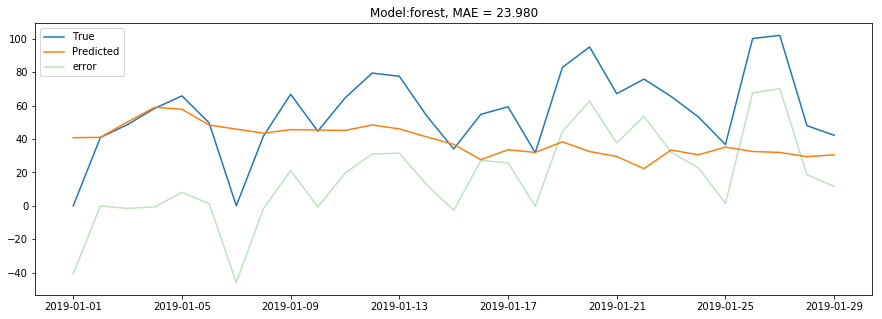

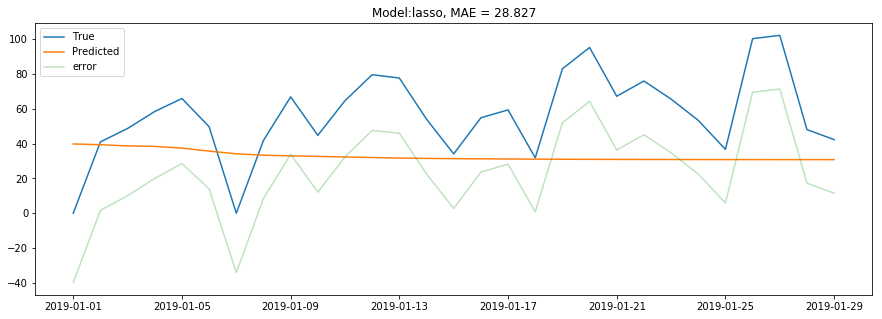

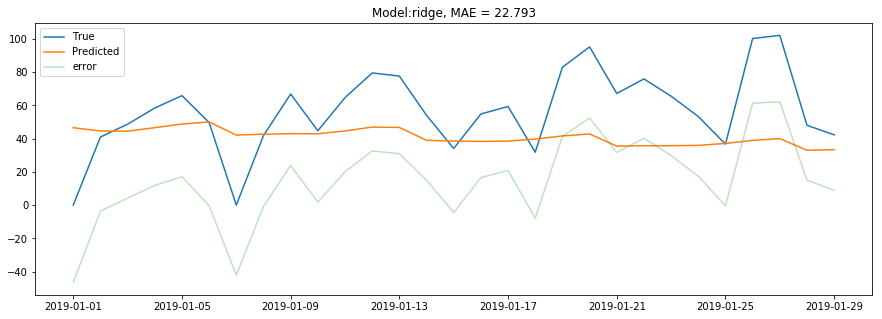

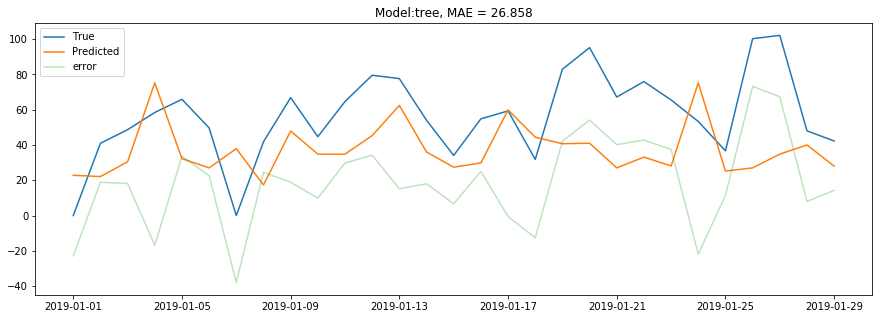

In [35]:
for model in models.items():
    model_to_chart(y=df_test.loc[:'2019-01-29'].values.ravel(), 
                y_pred= predicted_values.iloc[-30:-1][model[0]].values, 
                index = predicted_values.iloc[-30:-1].index, 
                model_name=model[0])

### Strategy 2 - "Predict K ticks ahead"

The main point of this strategy is in case when a forecasting horizont (P) less then amount of time steps those we want to predict (K) we are able to use only historical observations to generate features for predictions

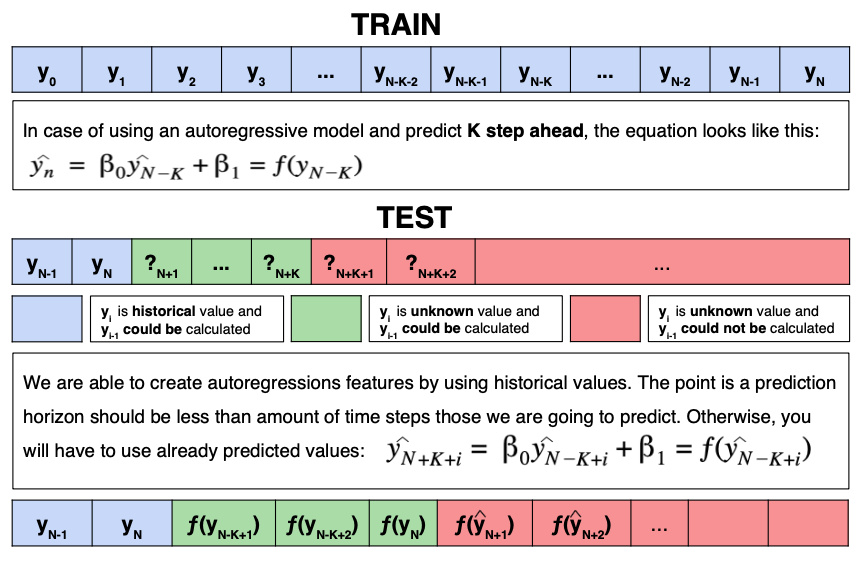

In [36]:
model_ridge_K = Ridge()
model_lasso_K = Lasso()
model_tree_K = DecisionTreeRegressor()
model_forest_K = RandomForestRegressor()
models_K = {'forest': model_forest_K,
          'lasso': model_lasso_K,
          'ridge': model_ridge_K,
          'tree': model_tree_K}

In [37]:
def create_features_K(data, windows, lag_start, lag_end):
    
    X = pd.DataFrame(data.values.ravel(), index=data.index, columns=['y'])
    
    for i in range(lag_start, lag_end):
        
        X['shift_{}'.format(i)] = X['y'].shift(i) 
    
    for window in windows:
    
        X['lin_reg_{}'.format(window)] = X['y'].shift(lag_start).rolling(window=window).apply(linreg, raw=True)
        X['diff_{}'.format(window)] = X['y'].shift(lag_start).diff(window)
        X['rolling_mean_{}'.format(window)] = X['y'].shift(lag_start).rolling(window=window).mean()
        X['rolling_max_{}'.format(window)] = X['y'].shift(lag_start).rolling(window=window).max()
        X['rolling_std_{}'.format(window)] = X['y'].shift(lag_start).rolling(window=window).std()
        X['rolling_min_{}'.format(window)] = X['y'].shift(lag_start).rolling(window=window).min()
        
    X = X.fillna(np.nanmedian(X))
    
    return X.drop('y', axis=1)

In [38]:
X_train = scaler(create_dummies(create_features_K(df_train, lags, lag_start=30, lag_end=40)))

In [39]:
df = pd.DataFrame()
for model in models_K.items():
    df[model[0]] = train(X_train, df_train.values.ravel(), model[1])

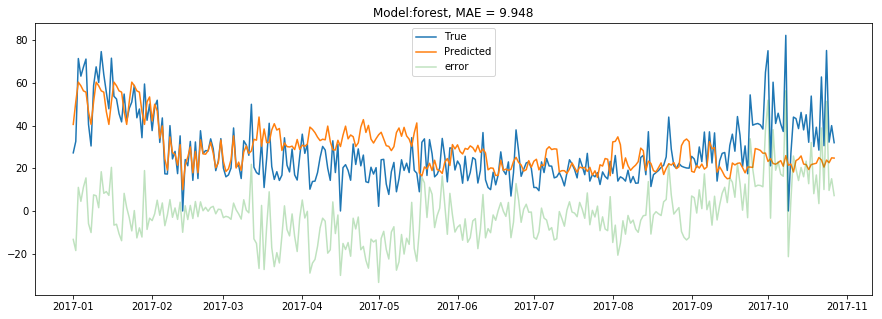

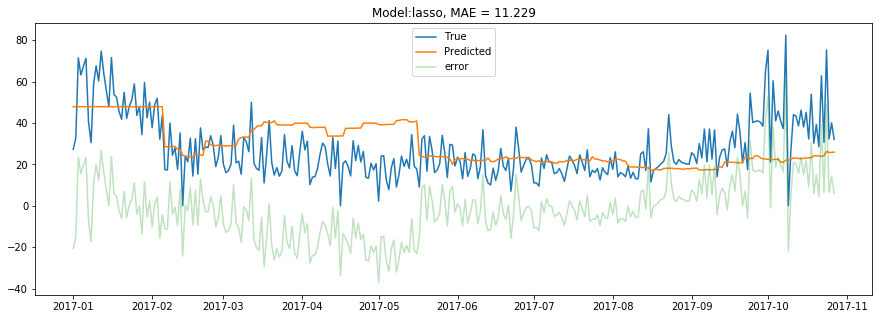

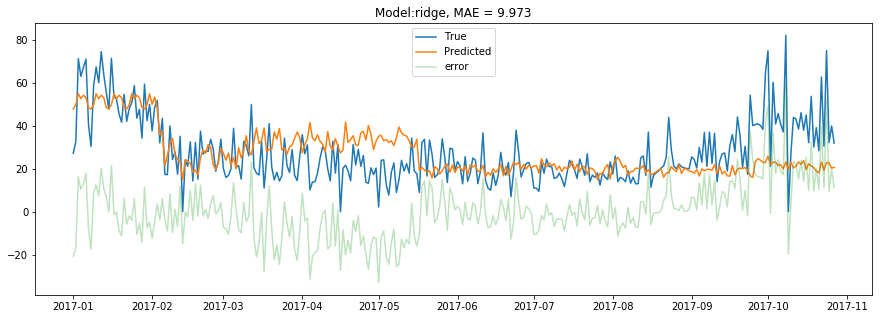

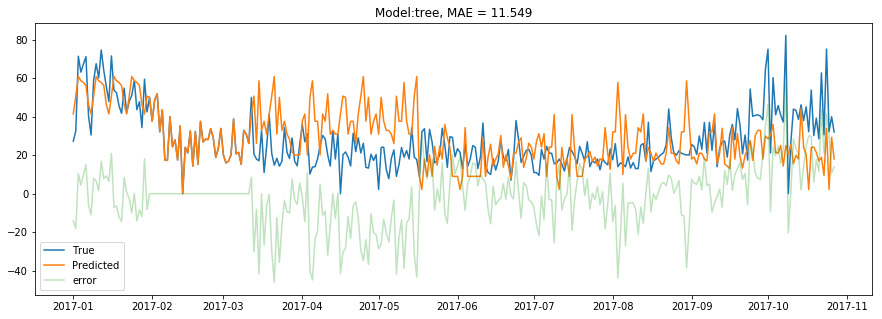

In [40]:
for model in models_K.items():
    model_to_chart(y=df_train[:300].values.ravel(), 
                y_pred= df[:300][model[0]].values, 
                index = df_train[:300].index, 
                model_name=model[0])

In [41]:
def forecast_maker_K(models, data, n_steps, windows, lag_start, lag_end):
    
    x_features = scaler(create_dummies(create_features_K(create_dates(data, n_steps), windows, lag_start, lag_end)))
    
    df = pd.DataFrame(index=x_features.iloc[-n_steps:].index)
    
    for model in models.items():
        
        df[model[0]] = np.nan
        df[model[0]] = model[1].predict(x_features.iloc[-n_steps:])
        
    return df

In [42]:
predicted_values_K = forecast_maker_K(models_K, df_train, n_steps=30, windows=lags, lag_start=30, lag_end=40)

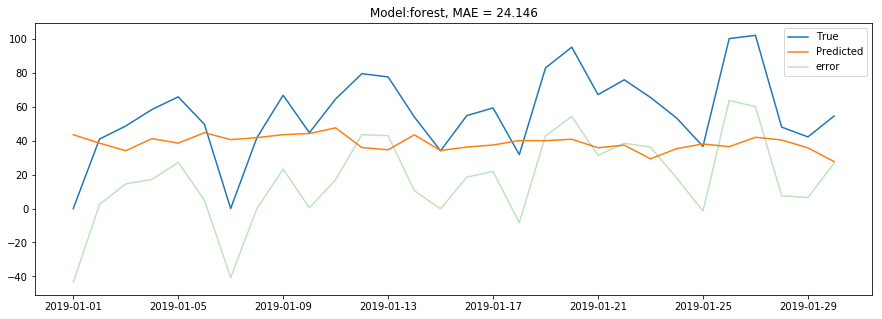

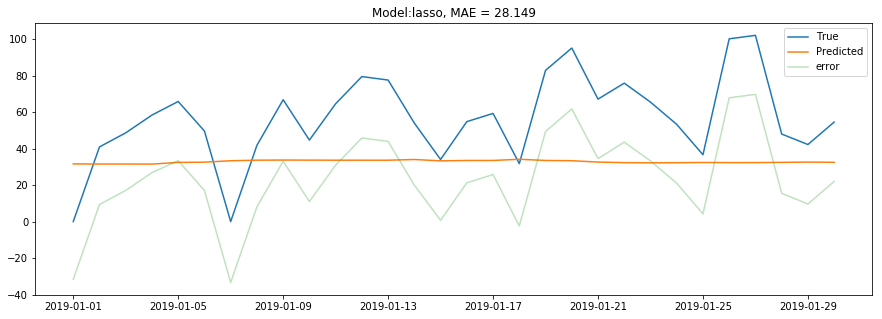

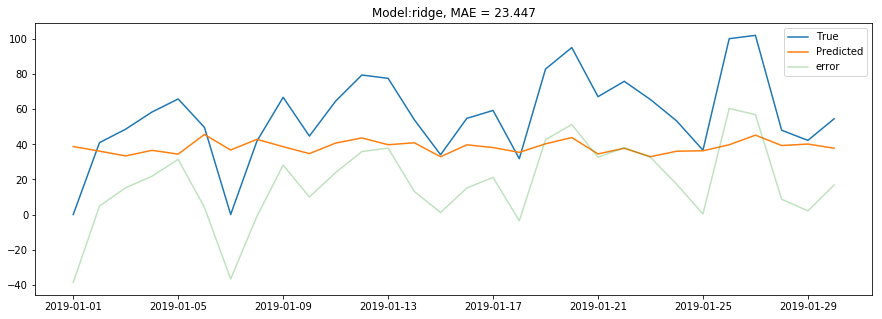

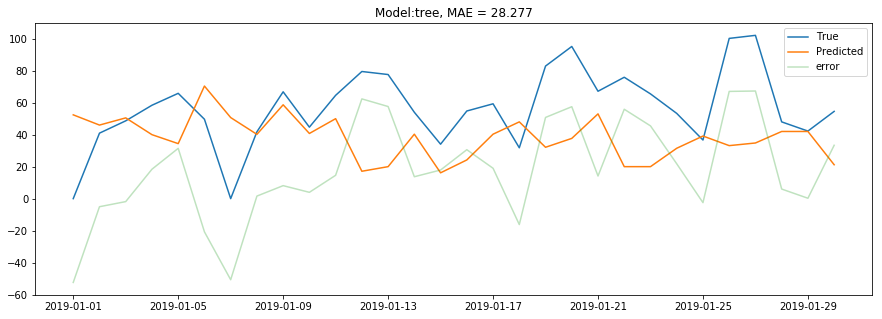

In [43]:
for model in models_K.items():
    model_to_chart(y=df_test.loc[:'2019-01-30'].values.ravel(), 
                y_pred= predicted_values_K[model[0]].values, 
                index = predicted_values_K.index, 
                model_name=model[0])

### Strategy 3 - "Combo"


The third strategy is the space for creativity. 
No one restrict us to combine different models:
- one model to predict 1 steps ahead
- another one to predict 2 steps 
- and etc.

In the example below I have combined 2 previously created and trained models.

Pay you attention that you have to pass to the function amount of time steps those should be predicted by using first model and numbers of ticks with made second one.

In [111]:
def forecast_maker_combo(models, models_K, data, first_stage, second_stage, windows, lag_end):
    
    x_features_K = scaler(create_dummies(create_features_K(create_dates(data, first_stage+second_stage), windows, first_stage, lag_end)))
    df = pd.DataFrame(index=x_features_K.iloc[-(first_stage+second_stage):].index)

    
    for model in models_K.items():
        
        df[model[0]] = np.nan

        df[model[0]].iloc[:first_stage] = model[1].predict(x_features_K.iloc[-first_stage:])
        
        for i in range(0, second_stage-1):
            
            x_features = scaler(create_dummies(create_features(df[model[0]], lags_list=windows, test=True))) #генерируем фичи и шкалируем 
            y_pred = np.round(models[model[0]].predict(x_features.iloc[-second_stage+i:-second_stage+i+1]), 2) #предсказывает новое значение
            
            df[model[0]].iloc[-second_stage+i] = y_pred #добавляет новое значение в df для соответствующей модели
        
    return df

In [112]:
predicted_values_combo = forecast_maker_combo(models, models_K, df_train, first_stage=20, second_stage=10, windows=lags,  lag_end=30)

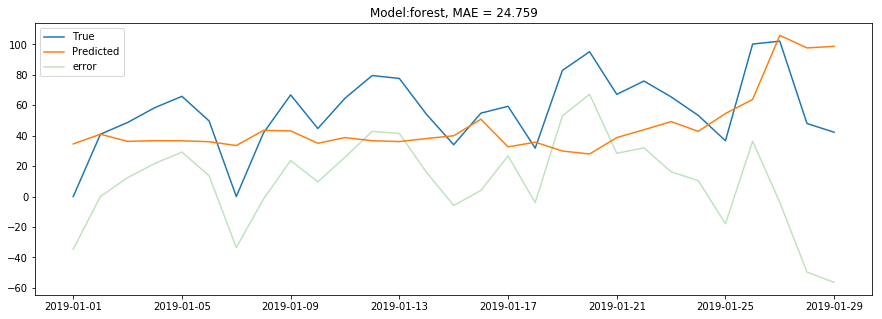

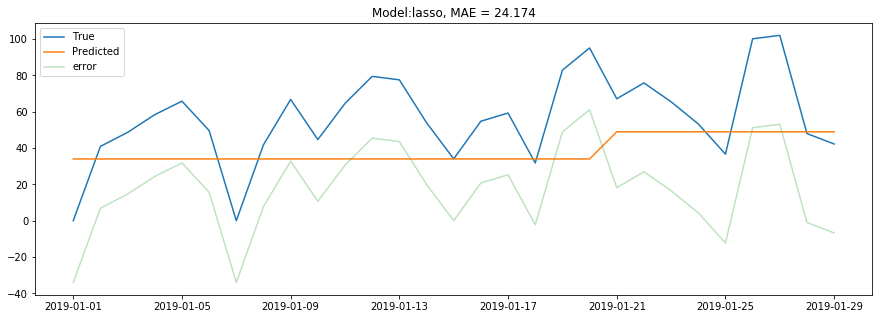

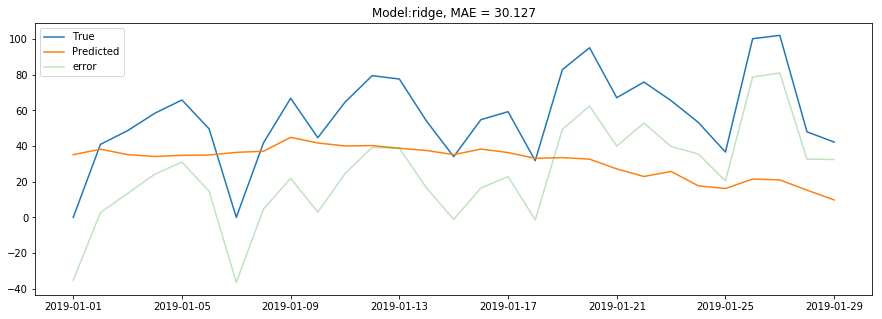

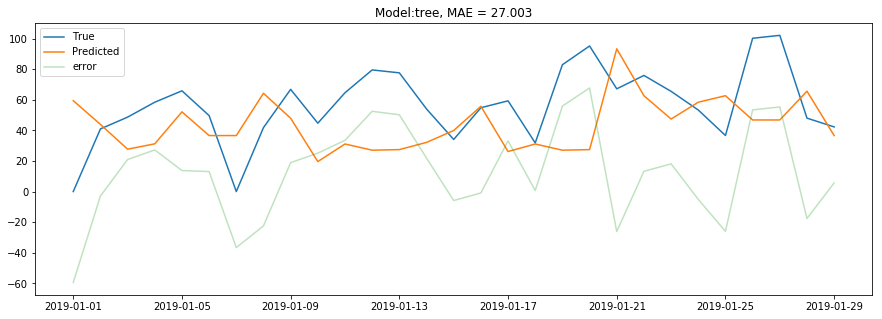

In [117]:
for model in models_K.items():
    model_to_chart(y=df_test.loc[:'2019-01-29'].values.ravel(), 
                y_pred= predicted_values_combo[model[0]].iloc[:-1].values, 
                index = predicted_values_combo.iloc[:-1].index, 
                model_name=model[0])